# Etapa 2 — Análise de Dados com AWS S3 e Pandas

## Importação das bibliotecas

- `boto3`: biblioteca oficial da AWS para acessar recursos como o S3.
- `pandas`: usado para manipulação e análise de dados tabulares.
- `io`: permite ler arquivos diretamente da memória (streaming do S3).
- `matplotlib.pyplot` e `seaborn`: utilizadas para criar gráficos e visualizações estatísticas.
- `botocore.exceptions`: tratamento de erros relacionados à autenticação e conexão com serviços AWS.

In [1]:
import boto3
import pandas as pd
import io

import matplotlib.pyplot as plt
import seaborn as sns

from botocore.exceptions import BotoCoreError, ProfileNotFound, NoCredentialsError

###  Criação da sessão AWS com perfil nomeado

- Inicia uma sessão autenticada com a AWS usando o perfil compass-sso, previamente configurado via aws configure sso.
- Cria um cliente para interagir com o serviço Amazon S3, permitindo ler, gravar e manipular objetos no bucket.
- Define o nome do bucket e o caminho do arquivo no S3.

In [2]:
try:
    session = boto3.Session(profile_name='compass-sso')
    s3 = session.client('s3')
    print("Conexão com o S3 estabelecida com sucesso!")
except ProfileNotFound:
    print(" Erro: Perfil 'compass-sso' não encontrado. Verifique se o perfil está configurado com aws configure.")
except NoCredentialsError:
    print(" Erro: Credenciais não encontradas. Configure suas credenciais AWS.")
except BotoCoreError as e:
    print(f" Erro ao conectar com a AWS: {e}")

Conexão com o S3 estabelecida com sucesso!


In [3]:
bucket_name = 'desafio-sprint4-8972'
key = 'bolsa_familia_2024.csv'

###  Leitura do arquivo CSV diretamente do bucket S3

- Recupera o objeto CSV armazenado no bucket definido, usando os parâmetros `bucket_name` e `key`.

In [4]:
try:
    obj = s3.get_object(Bucket=bucket_name, Key=key)
except Exception as e:
    print(f"Erro ao acessar o arquivo: {e}")

###  Carregamento do CSV em um DataFrame

- Lê o conteúdo do objeto S3 e converte em um DataFrame utilizando `pandas`.

In [5]:
df = pd.read_csv(io.BytesIO(obj['Body'].read()))

###  Renomeação das colunas para padronização

- Renomeia as colunas para nomes mais curtos e semânticos, facilitando a leitura e manipulação do DataFrame.

In [6]:
df.columns = df.columns.str.strip().str.lower()

df = df.rename(columns={
    'codigo_ibge': 'codigo_ibge',
    'anomes_s': 'ano_mes',
    'qtd_familias_beneficiarias_bolsa_familia_s': 'qtd_familias',
    'valor_repassado_bolsa_familia_s': 'valor_total_repassado',
    'pbf_vlr_medio_benef_f': 'valor_medio_repassado'
})

###  Conversão de coluna para tipo data

- Converte a coluna `ano_mes` para o tipo `datetime`, no formato `YYYYMM`, criando uma nova coluna chamada `data`.

In [7]:
df["data"] = pd.to_datetime(df["ano_mes"].astype(str), format="%Y%m")

###  Remoção de coluna redundante

- Remove a coluna `ano_mes`, que já foi convertida para `data` e não é mais necessária.

In [8]:
df = df.drop(columns=["ano_mes"])

### IMPORTANTE

A partir dos dados, realizei uma divisão estatística com base nos quartis da variável `qtd_familias`:

- **Baixa demanda**: até 510 famílias (abaixo do 25º percentil)
- **Média demanda**: entre 511 e 3.326 (entre os quartis 25% e 75%)
- **Alta demanda**: acima de 3.326 (acima do 75º percentil)

In [9]:
q1 = df["qtd_familias"].quantile(0.25)
q3 = df["qtd_familias"].quantile(0.75)

df["categoria_demanda"] = "Não classificado"

df.loc[df["qtd_familias"] <= q1, "categoria_demanda"] = "Baixa demanda"
df.loc[(df["qtd_familias"] > q1) & (df["qtd_familias"] <= q3), "categoria_demanda"] = "Média demanda"
df.loc[df["qtd_familias"] > q3, "categoria_demanda"] = "Alta demanda"

###  Q1 — Quais faixas de municípios concentram mais repasses acima da média nacional?

O objetivo foi identificar **quantos municípios em cada faixa de demanda** recebem **acima da média nacional de valor por família** (R$ 677,71).

- Calculei a quantidade total de municípios em cada faixa (nunique()) e quantos deles se destacam por receber acima da média nacional.
- Calculei a média nacional com base em todos os repasses (`mean()`).
- Agrupei os dados por município (`codigo_ibge`) e `categoria_demanda` para obter a média por município.
- Apliquei filtros com dois operadores lógicos (`&`) para cada faixa de demanda.
- Contei quantos municípios de cada categoria estão acima da média nacional.
- Por fim, construí um gráfico de barras para representar visualmente os resultados.


In [10]:
baixa = df[df['categoria_demanda'] == 'Baixa demanda']
quantidade_baixa = baixa['codigo_ibge'].nunique()

media = df[df['categoria_demanda'] == 'Média demanda']
quantidade_media = media['codigo_ibge'].nunique()

alta = df[df['categoria_demanda'] == 'Alta demanda']
quantidade_alta = alta['codigo_ibge'].nunique()

media_nacional = df['valor_medio_repassado'].mean()
media_por_municipio = df.groupby(["codigo_ibge", "categoria_demanda"])[["qtd_familias", "valor_medio_repassado"]].mean().reset_index()

filtro_baixa = media_por_municipio[
    (media_por_municipio["categoria_demanda"] == "Baixa demanda") &
    (media_por_municipio["valor_medio_repassado"] > media_nacional)
]

filtro_media = media_por_municipio[
    (media_por_municipio["categoria_demanda"] == "Média demanda") &
    (media_por_municipio["valor_medio_repassado"] > media_nacional)
]

filtro_alta = media_por_municipio[
    (media_por_municipio["categoria_demanda"] == "Alta demanda") &
    (media_por_municipio["valor_medio_repassado"] > media_nacional)
]

print(f"🔵 Baixa demanda: {len(filtro_baixa)} municípios recebem acima da média nacional ({quantidade_baixa} registros).")
print(f"🟠 Média demanda: {len(filtro_media)} municípios recebem acima da média nacional ({quantidade_media} registros).")
print(f"🔴 Alta demanda: {len(filtro_alta)} municípios recebem acima da média nacional ({quantidade_alta} registros).")


🔵 Baixa demanda: 460 municípios recebem acima da média nacional (1450 registros).
🟠 Média demanda: 1304 municípios recebem acima da média nacional (2878 registros).
🔴 Alta demanda: 784 municípios recebem acima da média nacional (1432 registros).


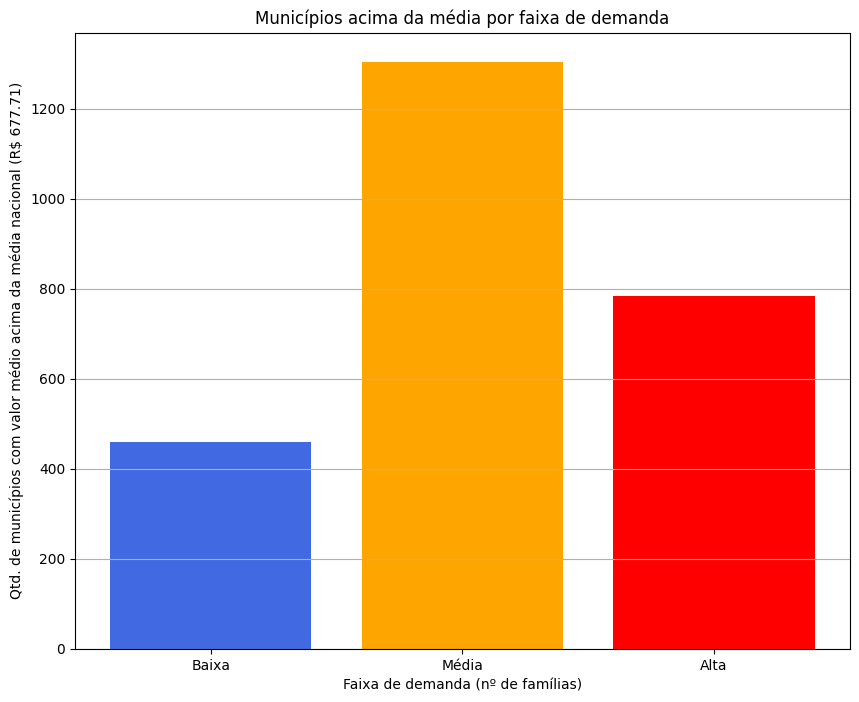

In [11]:
categorias = ["Baixa", "Média", "Alta"]
valores = [len(filtro_baixa), len(filtro_media), len(filtro_alta)]
cores = ["royalblue", "orange", "red"]

plt.figure(figsize=(10, 8))
plt.bar(categorias, valores, color=cores)
plt.title("Municípios acima da média por faixa de demanda")
plt.xlabel("Faixa de demanda (nº de famílias)")
plt.ylabel(f"Qtd. de municípios com valor médio acima da média nacional (R$ {media_nacional:.2f})")
plt.grid(axis="y")
plt.show()

### Q2 — Como o valor médio do benefício evolui ao longo do tempo em diferentes faixas de demanda?

Nesta etapa, o objetivo foi **analisar a evolução temporal** do valor médio do benefício por família ao longo do ano de 2024, segmentando os municípios por **faixa de demanda populacional**.

- Utilizei `groupby()` para calcular a **média mensal do valor repassado** por família para cada categoria.
- A média nacional (R$ 677,71) foi traçada como linha de referência no gráfico.
- O gráfico de linha permite **comparar a tendência mês a mês** entre as diferentes faixas de municípios.

In [12]:
media_por_categoria = df.groupby(["data", "categoria_demanda"])["valor_medio_repassado"].mean().reset_index()

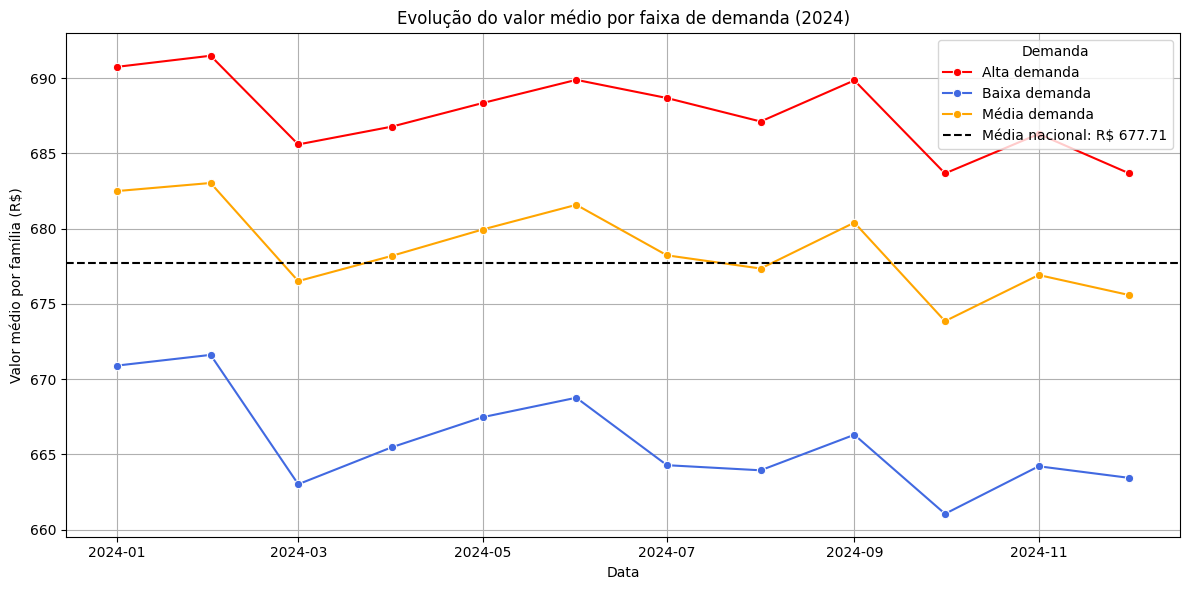

In [13]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=media_por_categoria,
    x="data",
    y="valor_medio_repassado",
    hue="categoria_demanda",
    marker="o",
    palette={"Baixa demanda": "royalblue", "Média demanda": "orange", "Alta demanda": "red"}
)
plt.axhline(media_nacional, color='black', linestyle='--', label=f"Média nacional: R$ {media_nacional:.2f}")

plt.title("Evolução do valor médio por faixa de demanda (2024)")
plt.xlabel("Data")
plt.ylabel("Valor médio por família (R$)")
plt.grid(True)
plt.tight_layout()
plt.legend(title="Demanda")
plt.show()

- **Municípios de alta demanda** mantêm os valores mais altos ao longo do tempo, com menor variação — indicando estabilidade orçamentária ou priorização na alocação.
- **Municípios de demanda média** seguem a mesma tendência, mas com valores um pouco inferiores.
- **Municípios de baixa demanda** apresentam os **valores mais baixos e maior oscilação**, sugerindo vulnerabilidade a variações sazonais ou ajustes administrativos.

###  Q3 — Qual a desigualdade interna em cada faixa de demanda em relação ao valor médio anual por família?

A intenção foi identificar como os repasses variam entre municípios de mesma faixa, revelando possíveis disparidades mesmo entre grupos semelhantes em termos de demanda.

- Utilizei um laço for passando por todo o df media_por_municipio, para obter o valor maximo e minimo repassado por categoria de demanda 
- Criei um grafico comparando o valor maximo e minio repassado por categoria de demanda

In [14]:
faixas = ['Baixa demanda', 'Média demanda', 'Alta demanda']
dados = []

for faixa in faixas:
    grupo = media_por_municipio[media_por_municipio['categoria_demanda'] == faixa]
    max_valor = grupo['valor_medio_repassado'].max()
    min_valor = grupo['valor_medio_repassado'].min()

    dados.append({
        'Faixa de Demanda': faixa,
        'Máximo': round(max_valor, 2),
        'Mínimo': round(min_valor, 2),
    })

df_extremos = pd.DataFrame(dados)

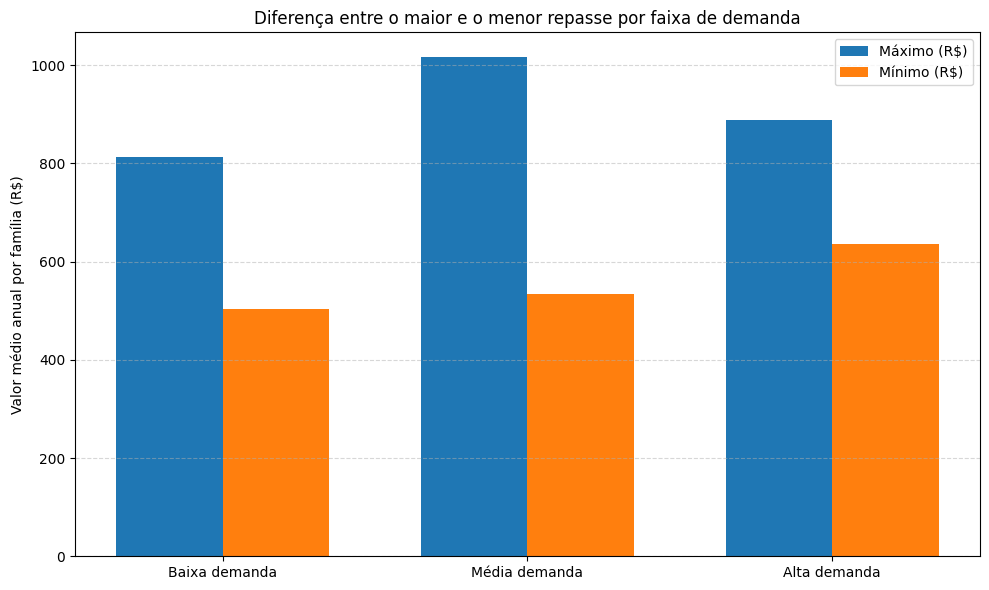

In [15]:
plt.figure(figsize=(10, 6))
bar_width = 0.35
x = range(len(df_extremos))

plt.bar(x, df_extremos['Máximo'], width=bar_width, label='Máximo (R$)')
plt.bar([i + bar_width for i in x], df_extremos['Mínimo'], width=bar_width, label='Mínimo (R$)')

plt.xticks([i + bar_width/2 for i in x], df_extremos['Faixa de Demanda'])
plt.ylabel("Valor médio anual por família (R$)")
plt.title("Diferença entre o maior e o menor repasse por faixa de demanda")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Salvar df limpo no bucket do S3

In [16]:
df.to_csv('bolsa_familia_2024_limpo.csv',index=False)

In [17]:
csv_buffer = io.StringIO()
df.to_csv(csv_buffer, index=False)

s3.put_object(Bucket=bucket_name, Key="bolsa_familia_2024_limpo.csv", Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'YKT18YB5TV42S1BZ',
  'HostId': 'm7izyHKy0dbGHaHuStZC9tHC0opLmC4F3+cJlmL5YZF8g3vSde/FaPkDK9MGge9Lik3OsFg7LDg=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'm7izyHKy0dbGHaHuStZC9tHC0opLmC4F3+cJlmL5YZF8g3vSde/FaPkDK9MGge9Lik3OsFg7LDg=',
   'x-amz-request-id': 'YKT18YB5TV42S1BZ',
   'date': 'Thu, 29 May 2025 15:09:12 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"e9d7115ab12434802dd6666c7ffda29c"',
   'x-amz-checksum-crc32': '1KFqvg==',
   'x-amz-checksum-type': 'FULL_OBJECT',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"e9d7115ab12434802dd6666c7ffda29c"',
 'ChecksumCRC32': '1KFqvg==',
 'ChecksumType': 'FULL_OBJECT',
 'ServerSideEncryption': 'AES256'}